# Brute-force detection of a time step

Imagine a timeseries that consists of 2 plateaux connected by a short down ramp.

The frequency distribution of such a timeseries will have 2 humps: one centered on the values of the first plateau level, the other centred on those of the second plateau.

We can measure how well a timeseries $S$ fits this model, i.e. to what extent is has a bimodal frequency distribution, by:

- considering it as two subseries $S = [A, B]$ split at an arbitrary point
- computing the difference between the standard deviations $\sigma(S)-\sigma(A)-\sigma(B)$
- maximising this difference over all possible bisections

In addition, to find series that step down rather than up we can stipulate that $E(A)>E(B)$

I've executed this below for the "total items" timeseries at the BNF chemical level.

In [17]:
%pylab inline
import pandas as pd
from hscictools import bnf,ccg,gbq # my local stuff
from datetime import datetime

Populating the interactive namespace from numpy and matplotlib


# Get the data from ebmdatalab project in BigQuery

See comments in gbq.py for how to configure using gcloud command line tool.

In [18]:
df=gbq.query(
    '''
    select TIMESTAMP_TO_MSEC(month) PERIOD,left(bnf_code,9) BNF_CHEMICAL,sum(actual_cost) TOTAL_ACT_COST,sum(items) TOTAL_ITEMS
    from [hscic.prescribing]
    group by PERIOD,BNF_CHEMICAL
    ''',
    max_rows=200000,index=['BNF_CHEMICAL','PERIOD'],
    cast={'TOTAL_ACT_COST':float,'TOTAL_ITEMS':float,'PERIOD':lambda t:datetime.fromtimestamp(int(t)/1000)},
    cachedir='/var/gbq',dirty=False
)

Reading cached results from /var/gbq/765a97ae354b9138800d16cf7c441a4a.json
140721 rows converted to DataFrame in 0.82 seconds


In [19]:
df.head()

TOTAL_ACT_COST  TOTAL_ITEMS
BNF_CHEMICAL PERIOD                                          
0206020F0    2010-10-01 01:00:00      2192636.88       354469
0404000S0    2015-05-01 01:00:00       584598.64         8239
0407010F0    2015-05-01 01:00:00      7237368.15      1263928
200309000    2012-12-01 00:00:00      2208071.03        60718
1304000D0    2012-12-01 00:00:00       187058.84        23685

# Apply the scoring and plot the highest scoring chemicals

I'm looking for steps in TOTAL_ITEMS - plotted in green. I also include TOTAL_ACT_COST - in blue with its scale on the right - in case it's useful.

Since we aleady evaluated some of these chemicals in the previous notebook, I'll use different colours in their plots (magenta and cyan).

In [24]:
seen='''0205052V0 Valsartan
0406000J0 Domperidone
1003020R0 Piroxicam
1201010G0 Hydrocortisone Acetate
0202040B0 Co-Amilofruse (Amiloride HCl/Frusemide)
1304000H0 Clobetasone Butyrate
1201010Q0 Hydrocortisone
0904010U0 Gluten Free/Wheat Free Bread
1201010F0 Flumetasone Pivalate
1003020M0 Felbinac
1003020T0 Nicotinates
0212000AB Omega-3-Acid Ethyl Esters
1001010C0 Diclofenac Sodium
0103030S0 Sucralfate
0401010T0 Temazepam
0906011D0 Vitamin A
040101000 Other Hypnotic Preps
210200002 Catheters
200306005 Wound Management & other Dressings
1001010N0 Mefenamic Acid
1108010Q0 Polyvinyl Alcohol
0206040AE Naftidrofuryl Oxalate
238006080 Skin Fillers And Protectives
1310011M0 Mupirocin
0904010AA Gluten Free/Wheat Free Mixes
190201000 Other Individually Form Bought In Preps
0401020E0 Chlordiazepoxide Hydrochloride
0410020B0 Nicotine Dependence
1203040G0 Hexetidine
020400040 Co-Tenidone (Atenolol/Chlortalidone)
1001022G0 Hydrocortisone Acetate
0205051K0 Lisinopril with Diuretic
200900005 Stockinette
0209000L0 Dipyridamole
0407041F0 Ergotamine Tartrate
1202010P0 Sodium Cromoglicate
0212000V0 Omega-3 Marine Triglycerides
0501030F0 Demeclocycline Hydrochloride
1108010N0 Paraffin Yellow Soft
0604011H0 Estradiol, Estriol and Estrone'''.split('\n')
seen=set(x.partition(' ')[0] for x in seen)

In [ ]:
def score(x):
    if len(x)>12:
        try:
            ps=[p for p in range(3,len(x)-2) if np.mean(x[:p])>np.mean(x[p:])]
            if ps:
                sd=np.std(x)
                return max([sd-np.std(x[:p])-np.std(x[p:]) for p in ps])
        except Exception, e:
            print e
    else:
        return -1

#NB must sort index of df, as the score function assumes values are organised in time order (groupby preserves the order)
scores=df.sort().groupby(level=0).agg(score)

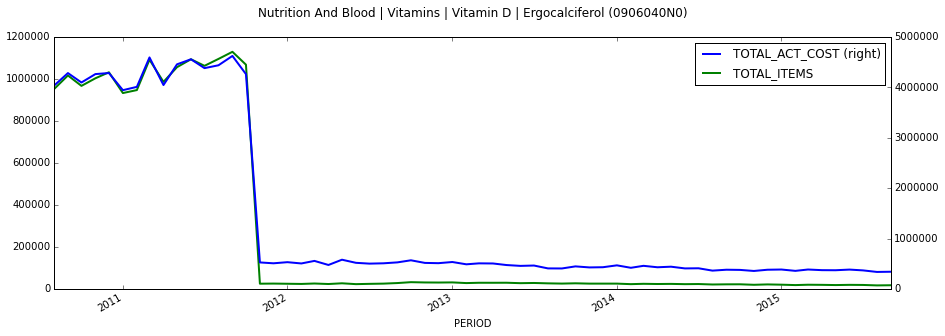

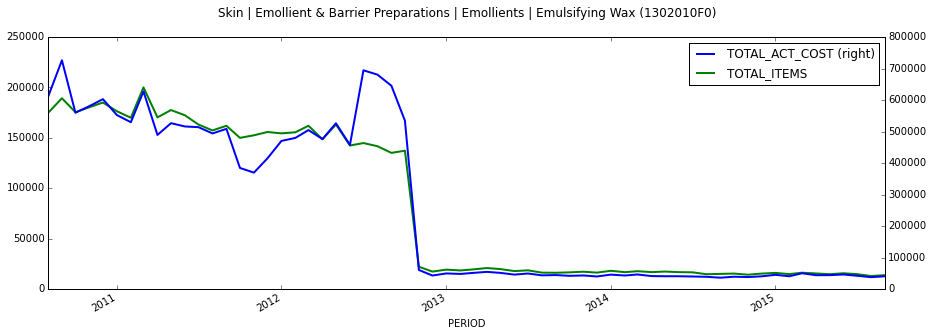

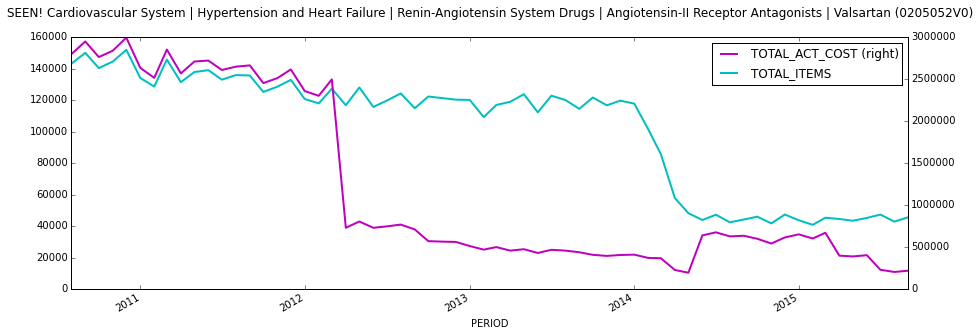

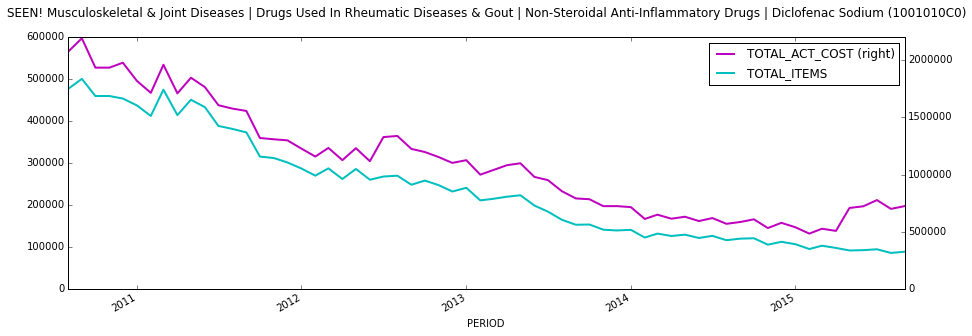

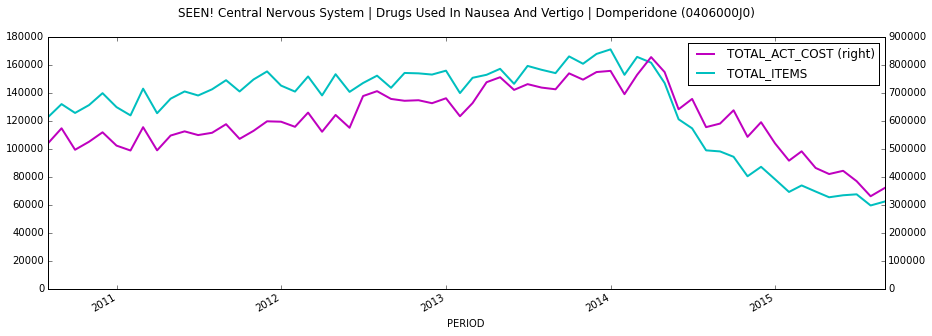

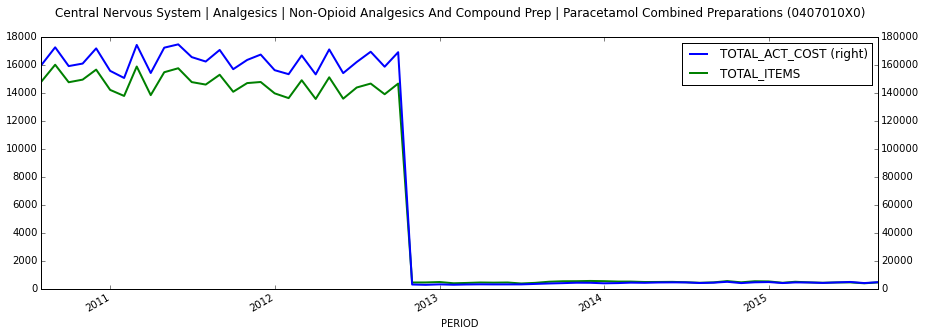

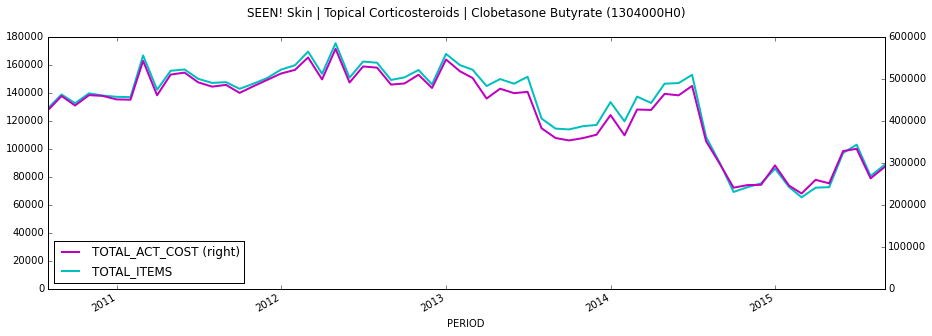

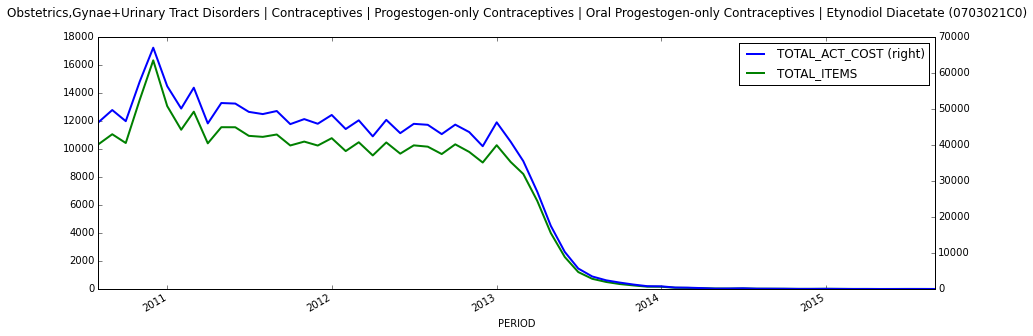

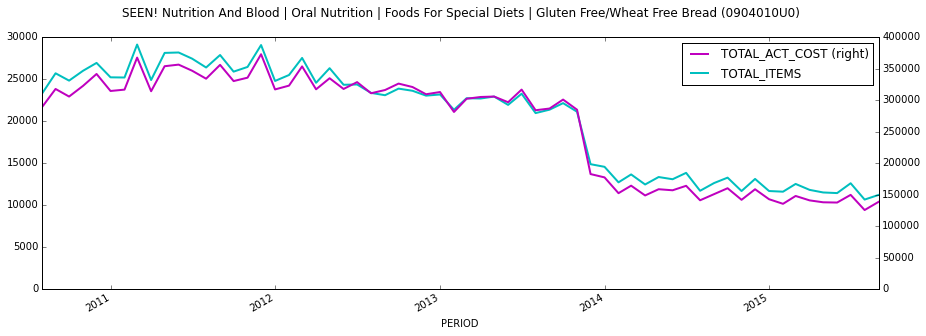

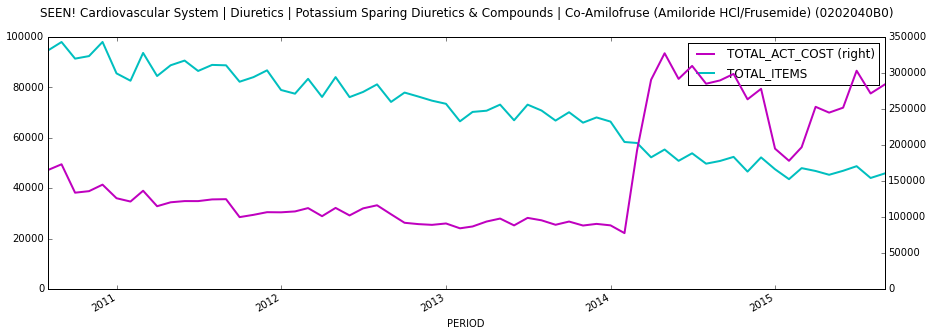

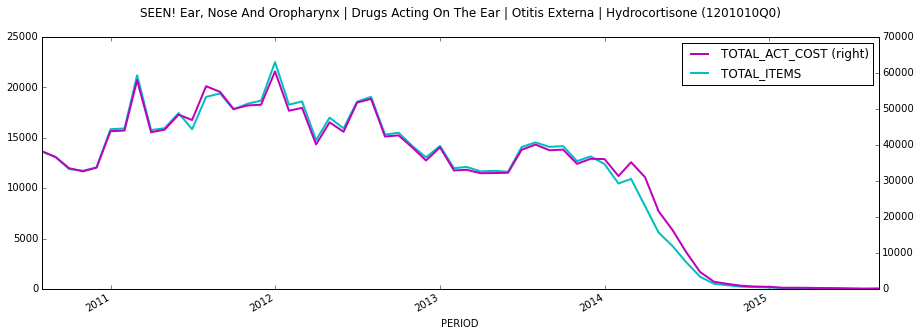

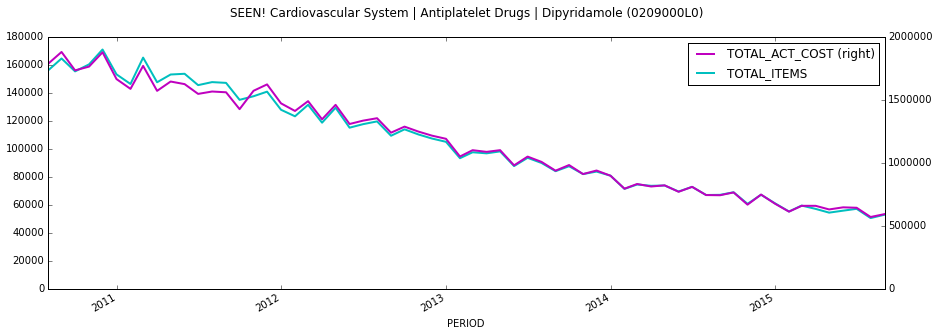

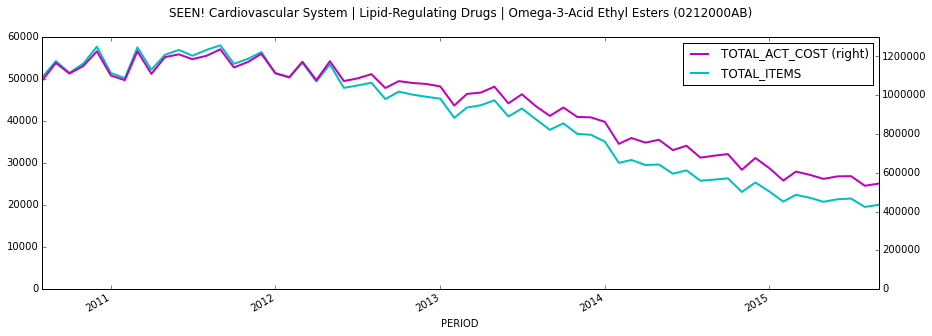

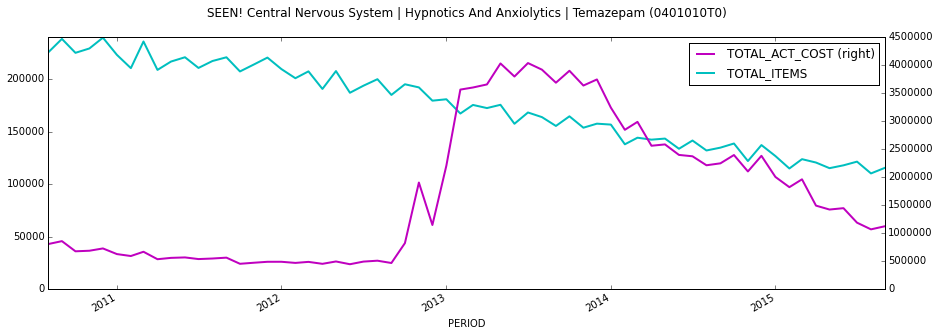

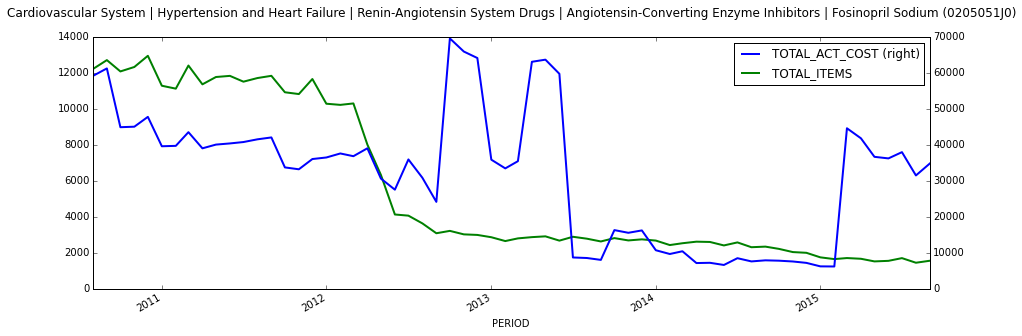

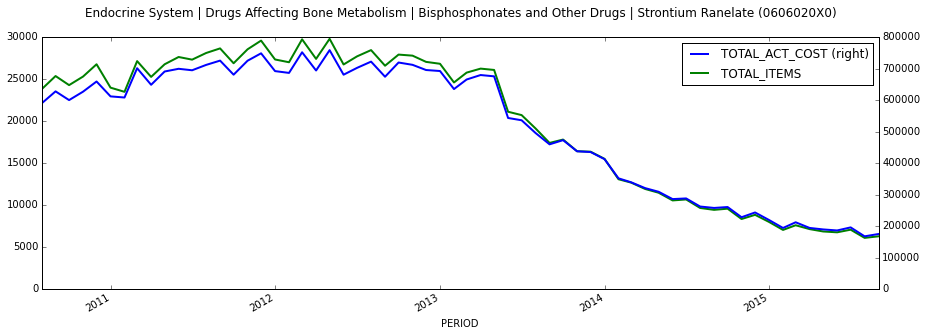

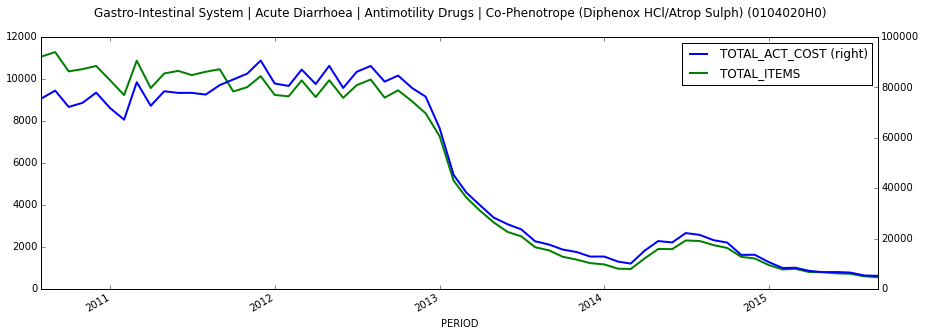

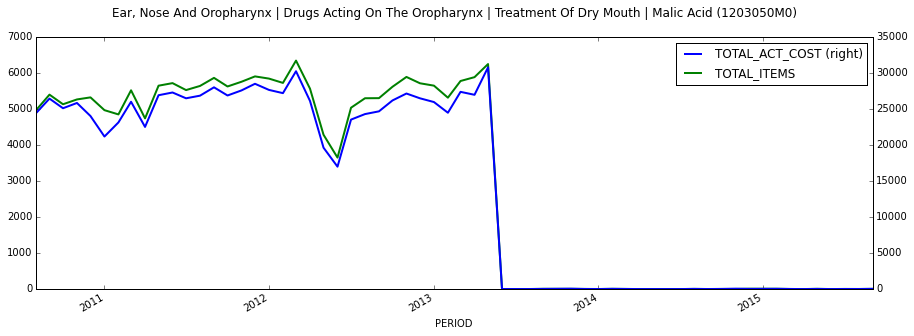

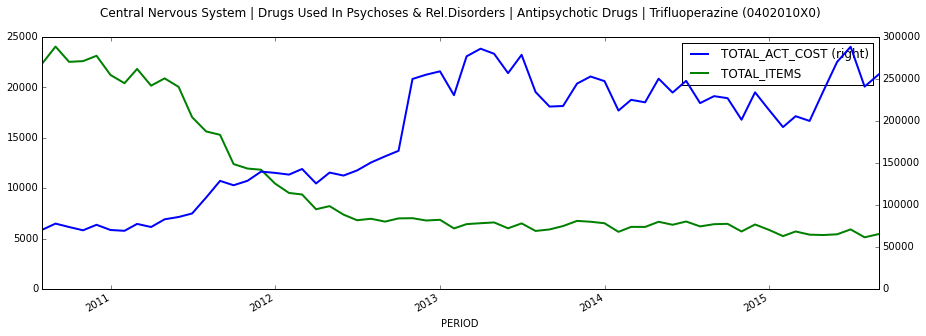

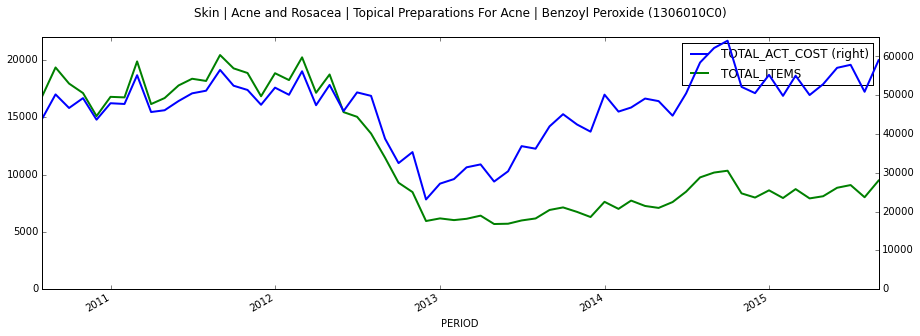

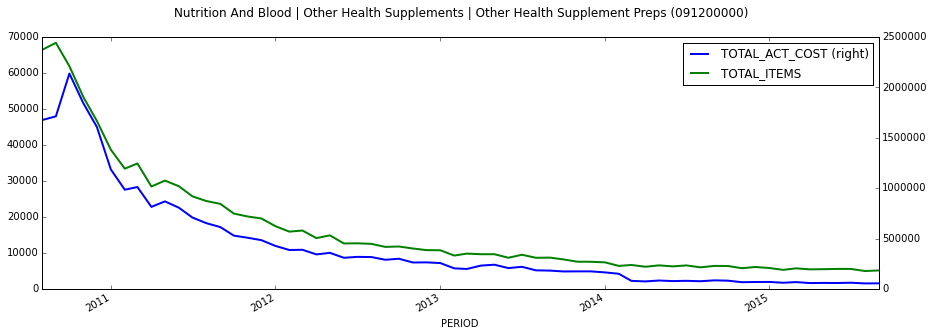

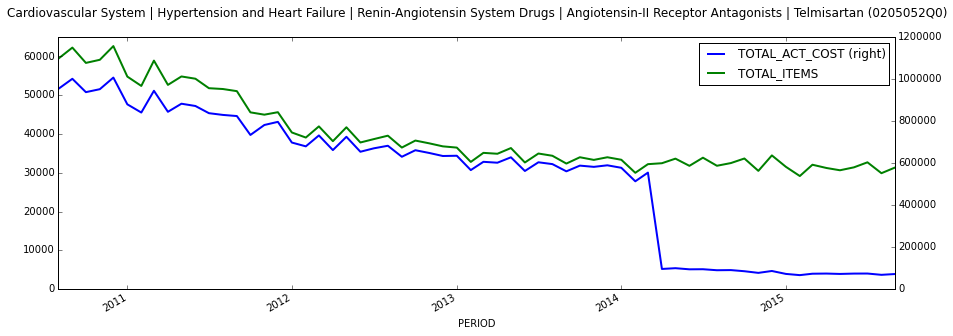

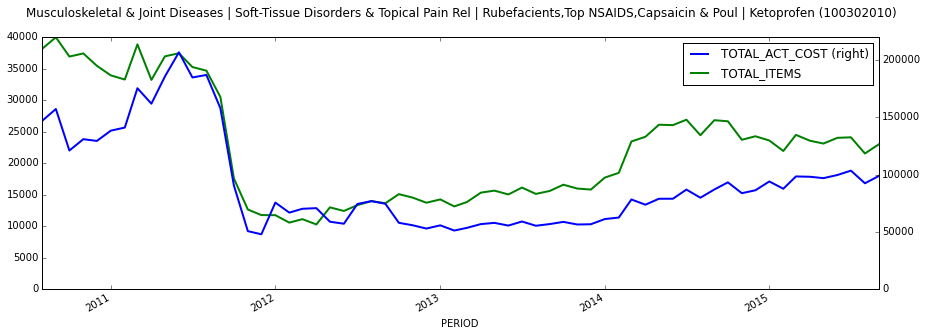

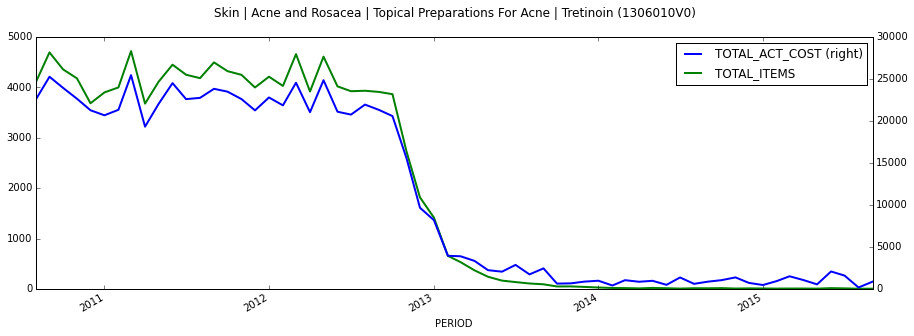

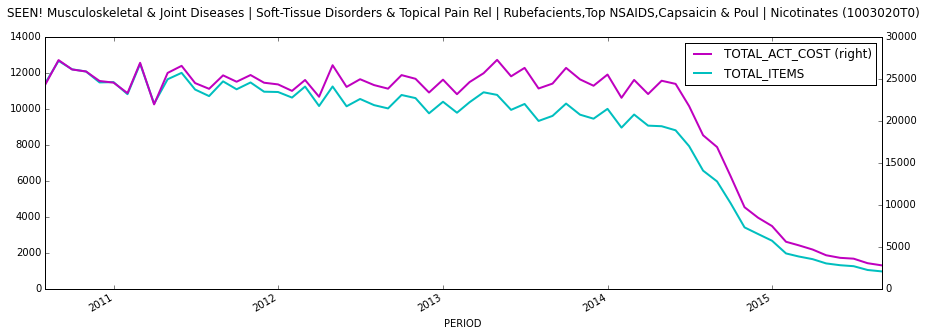

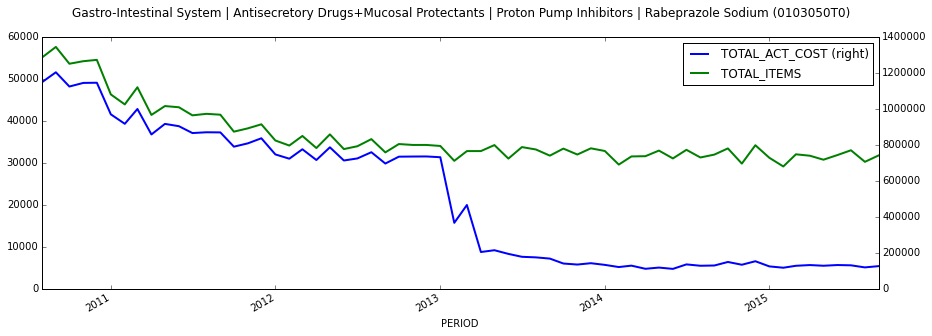

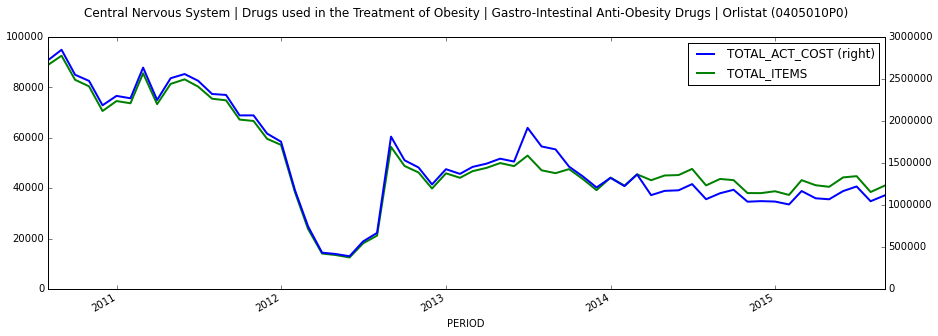

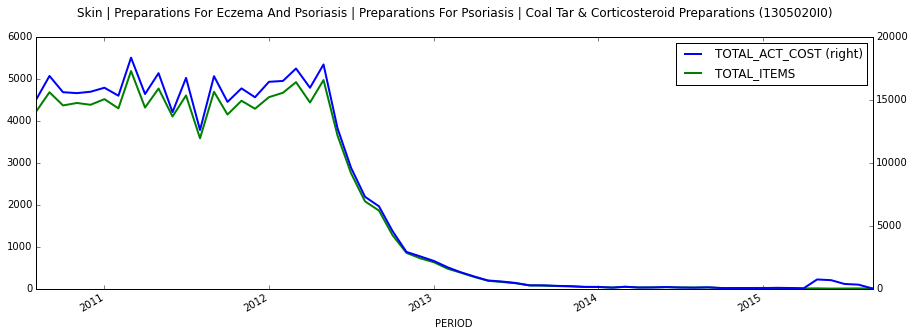

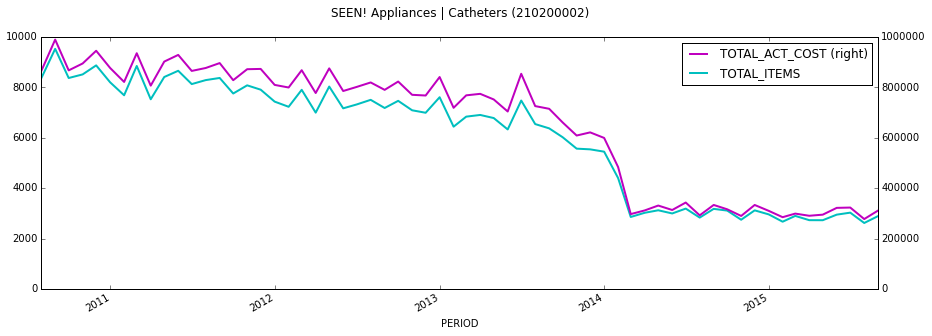

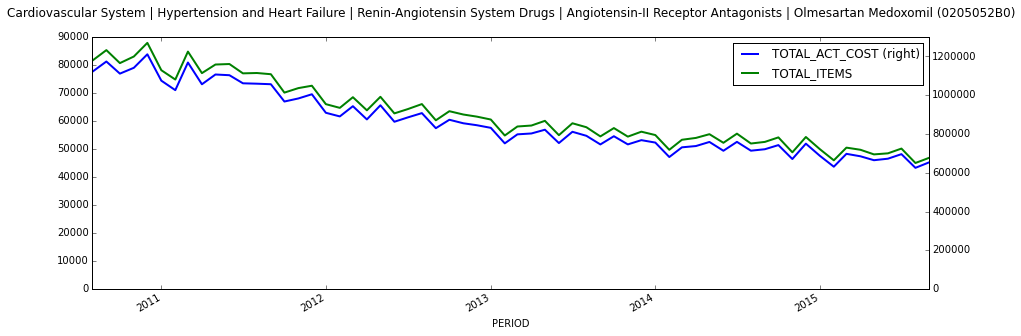

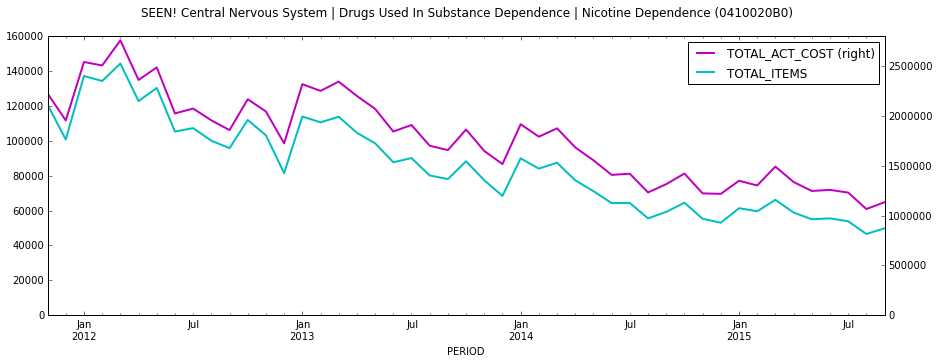

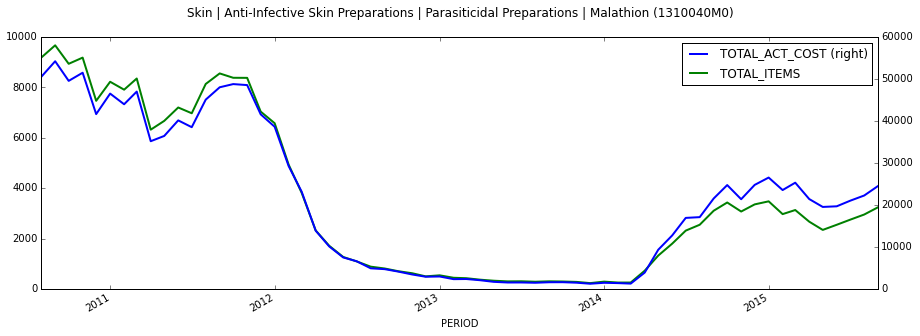

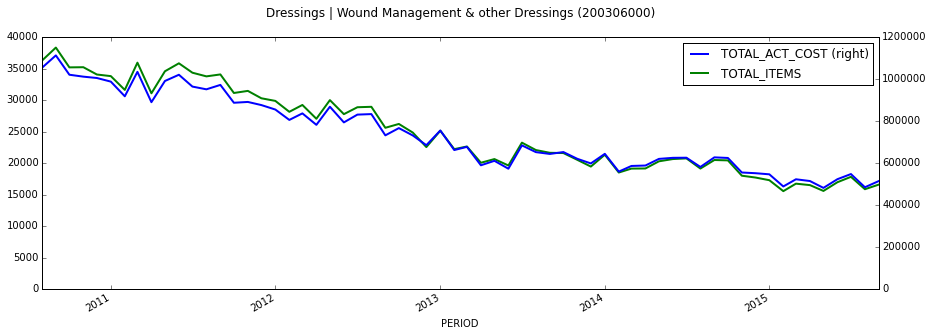

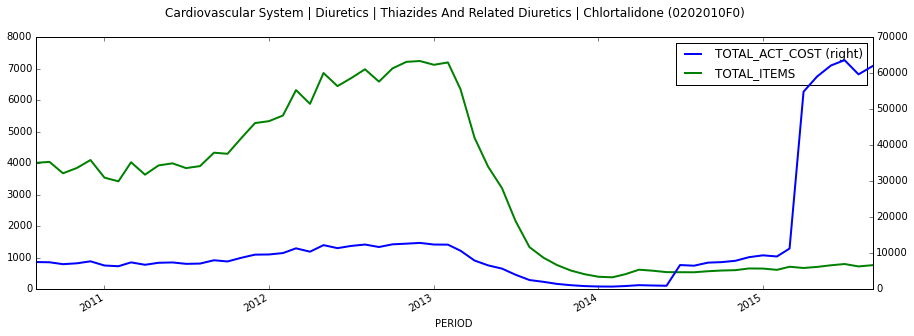

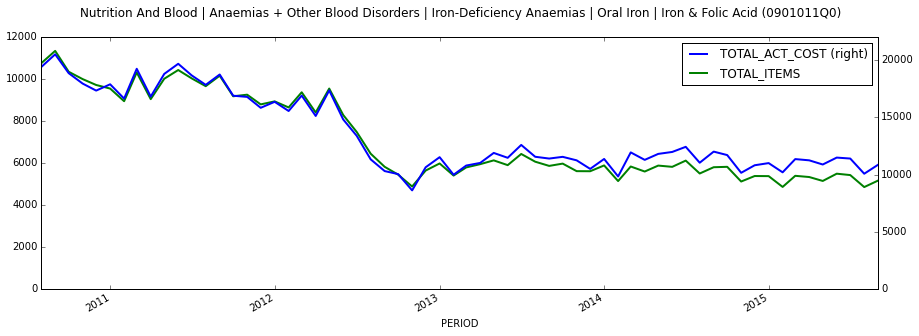

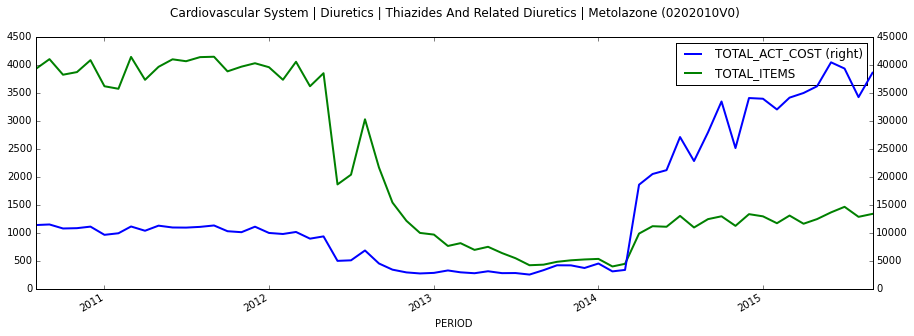

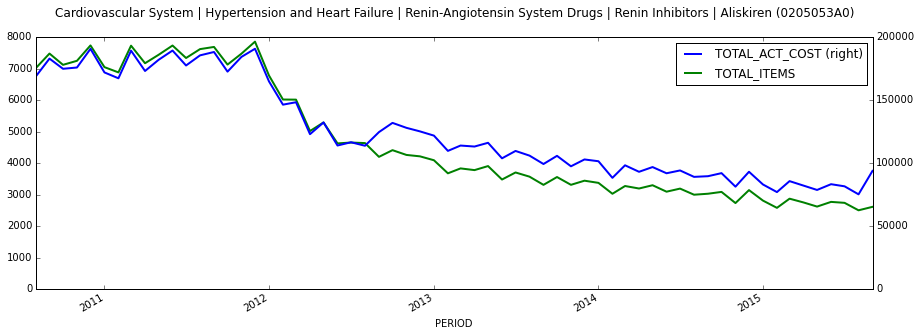

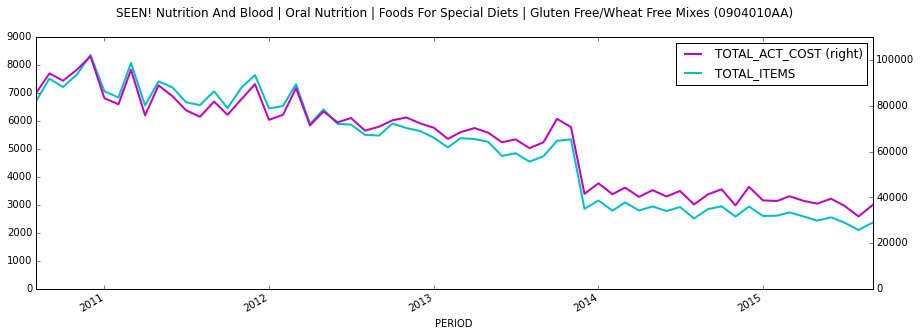

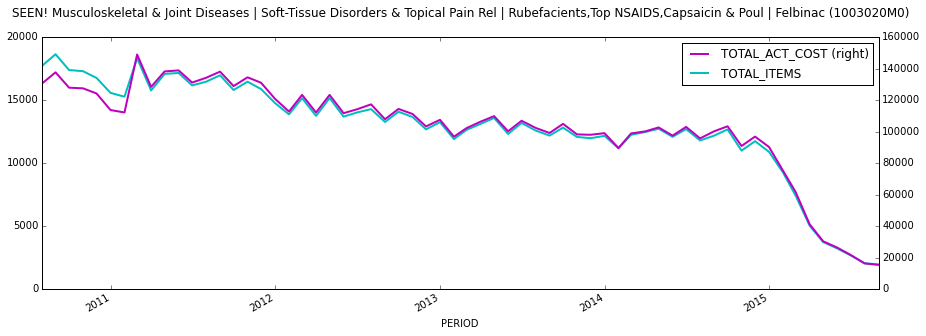

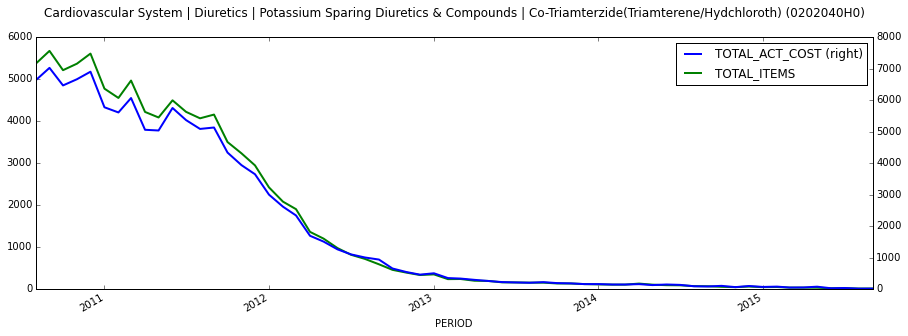

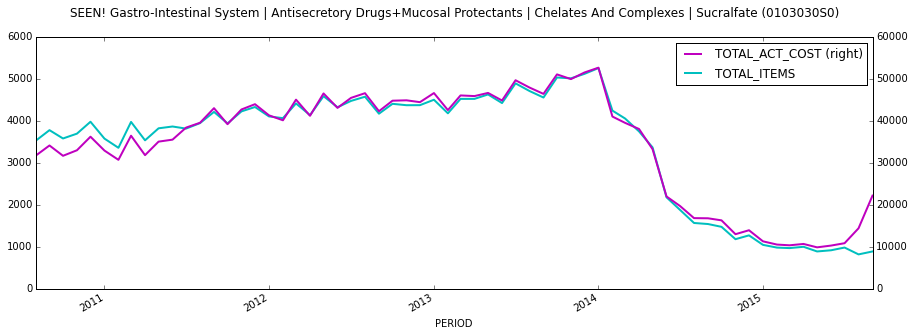

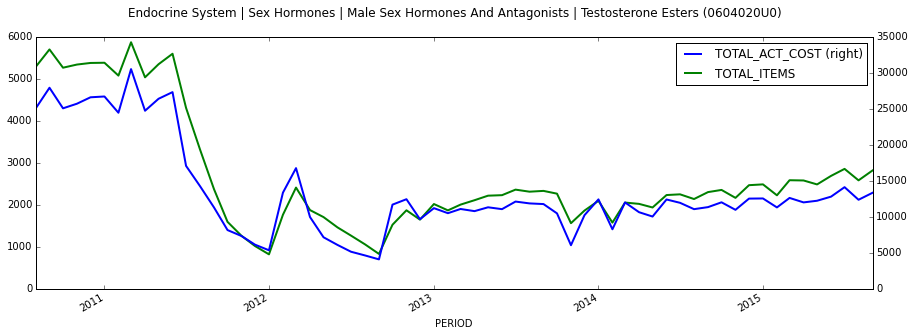

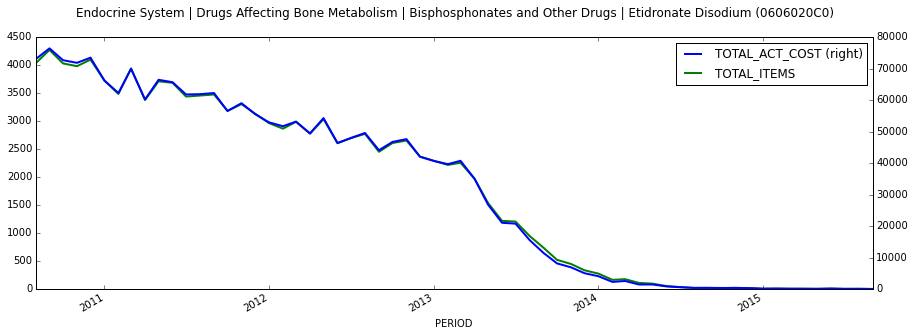

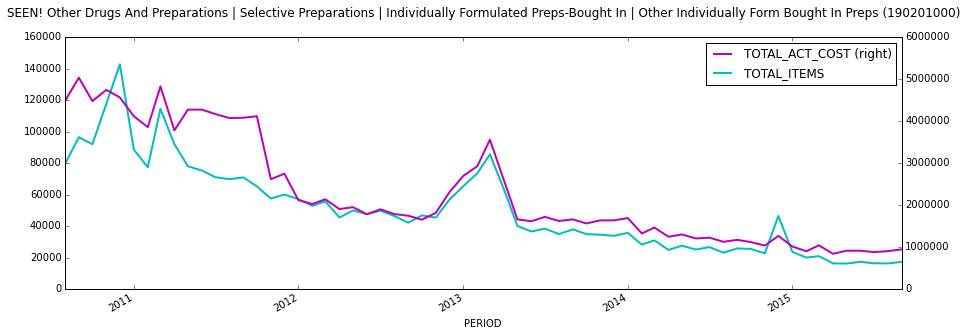

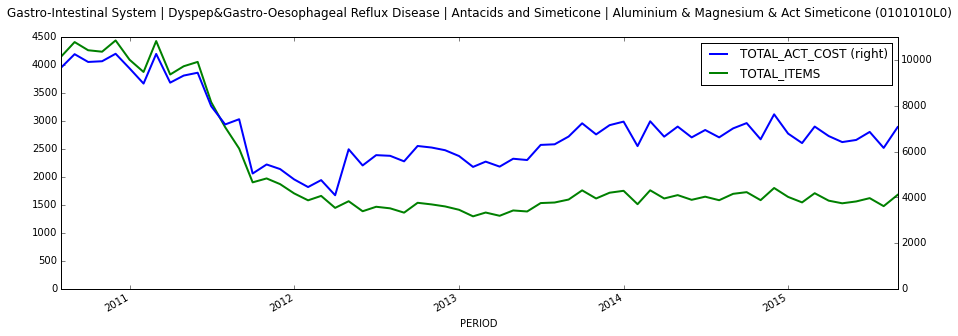

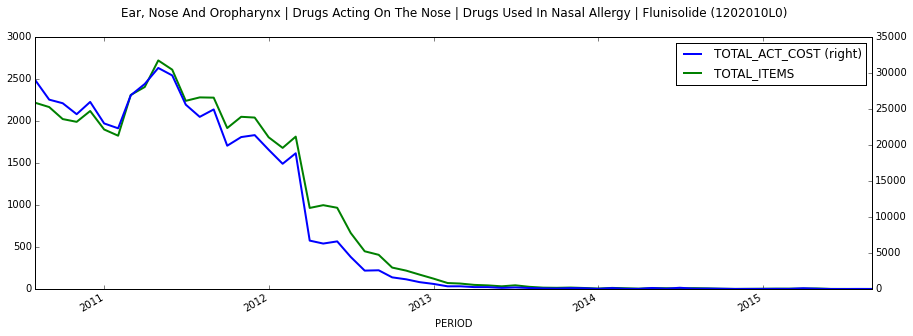

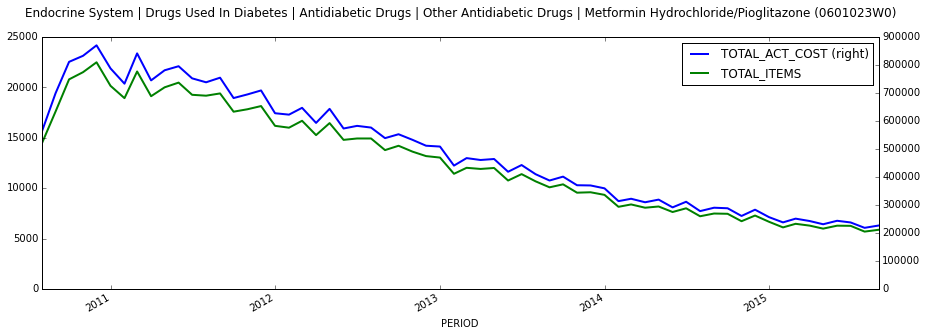

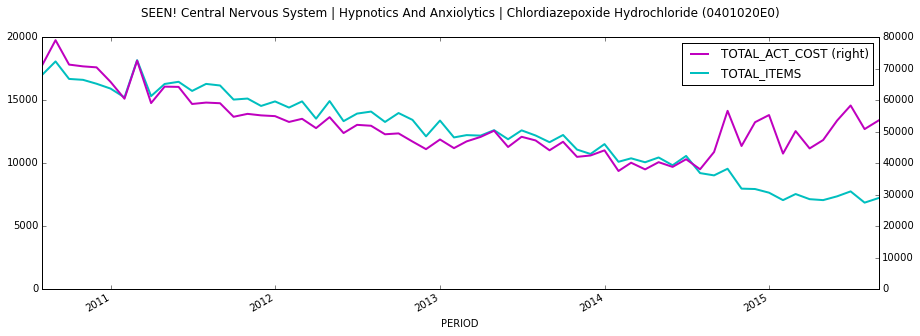

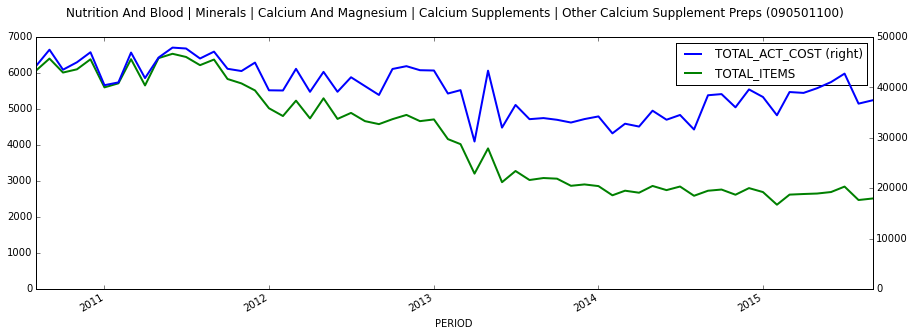

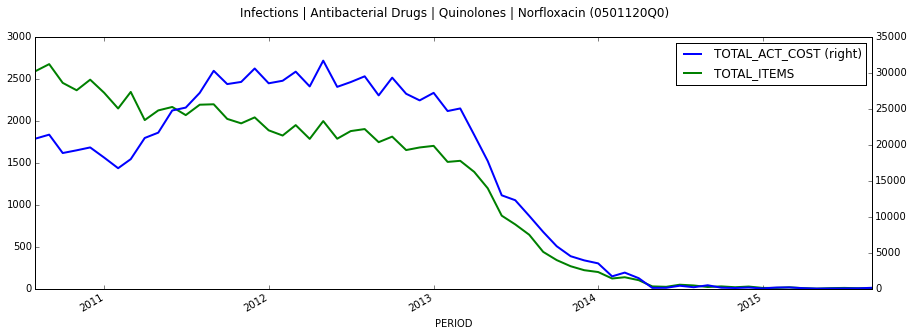

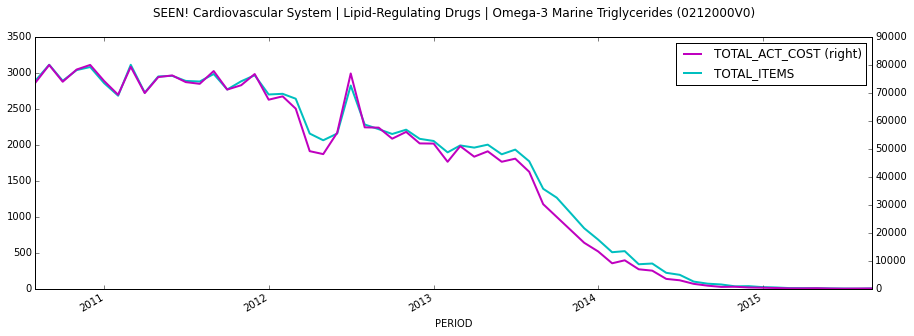

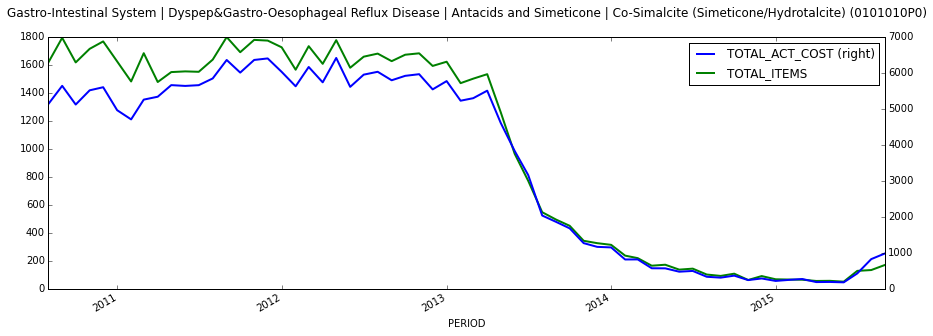

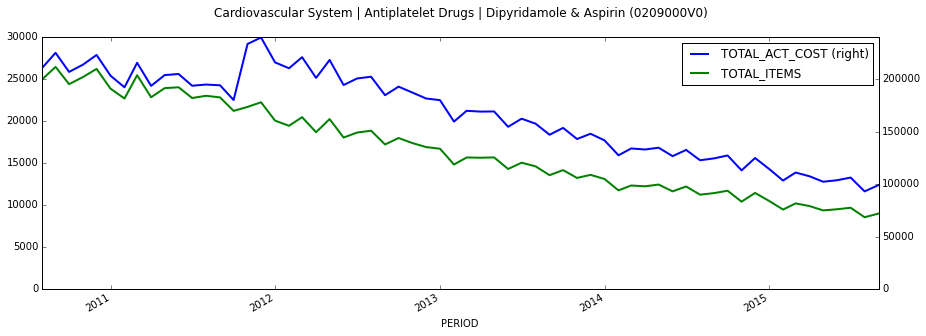

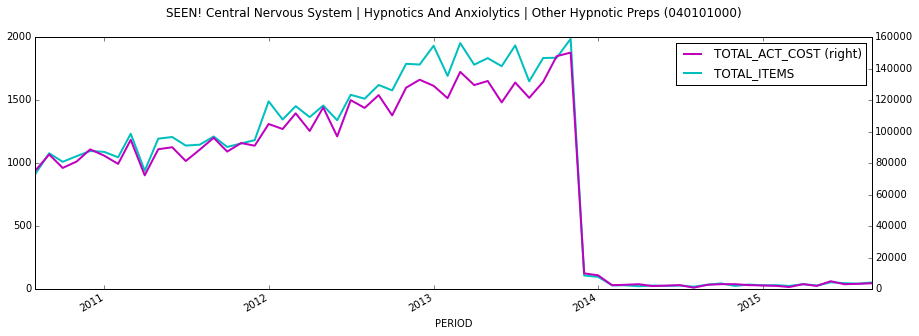

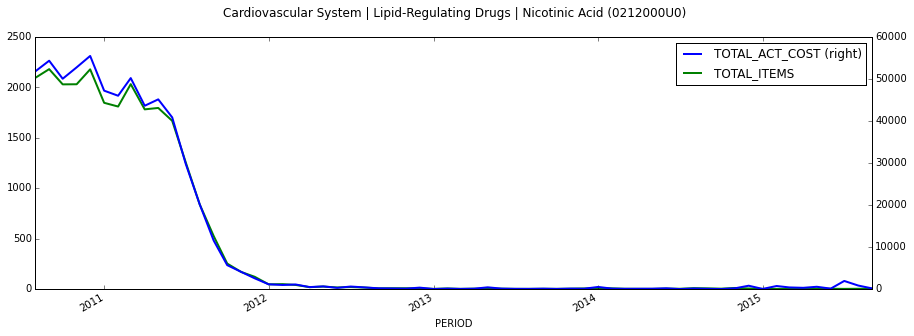

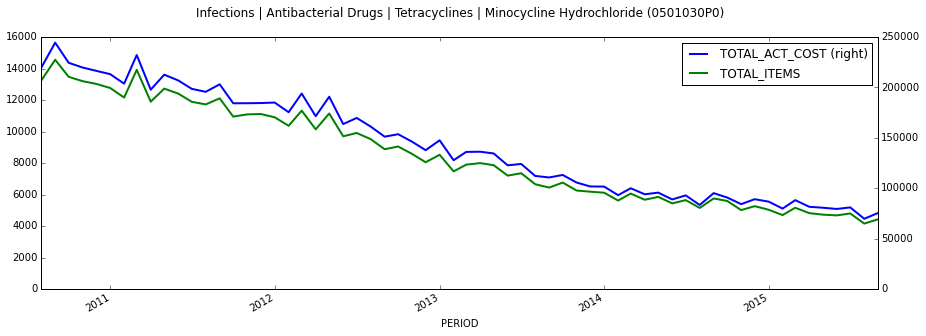

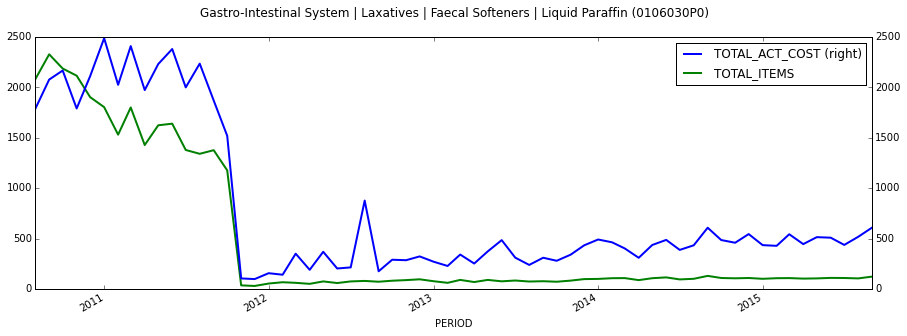

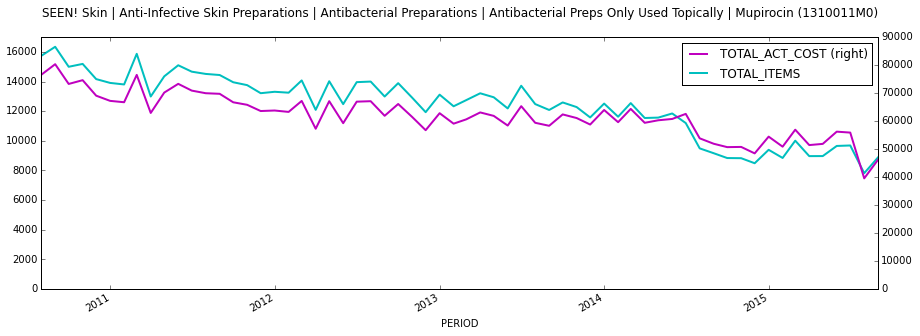

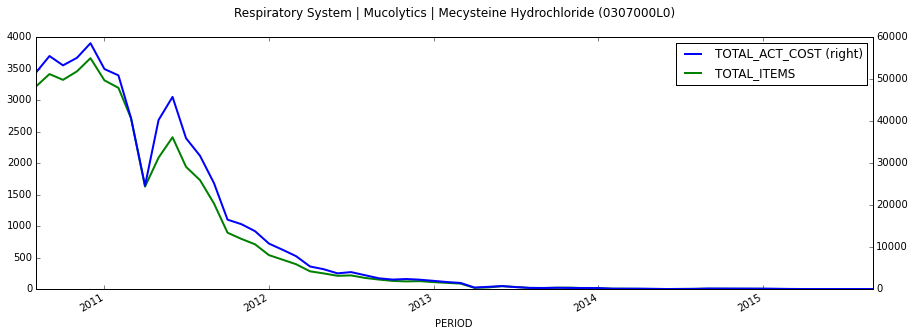

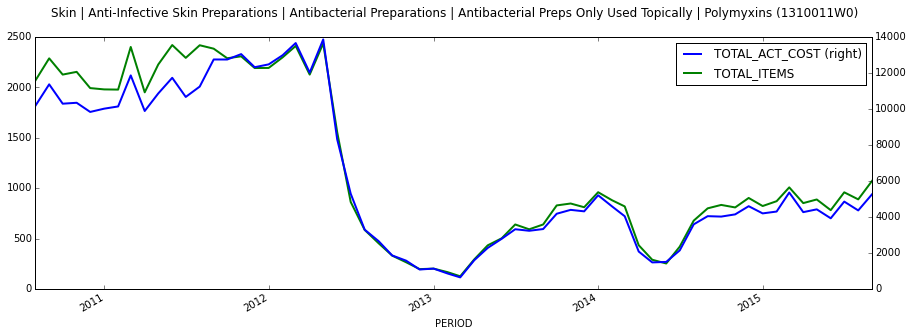

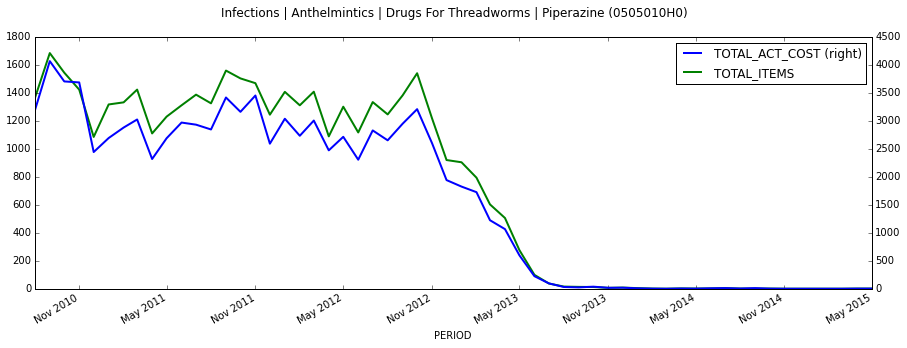

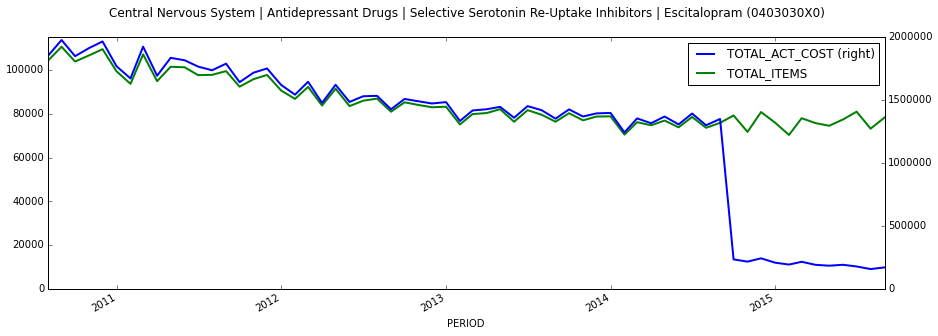

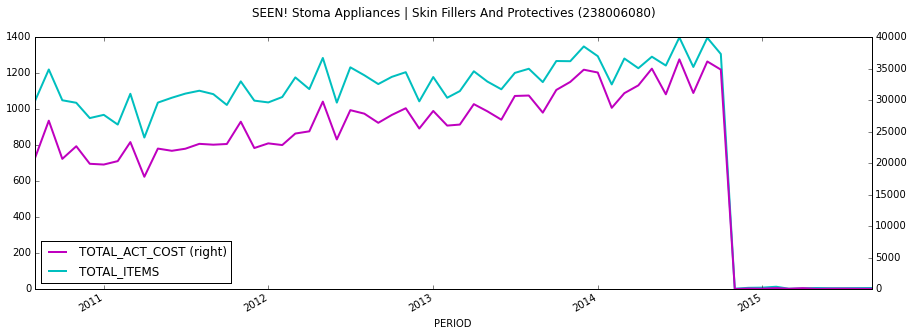

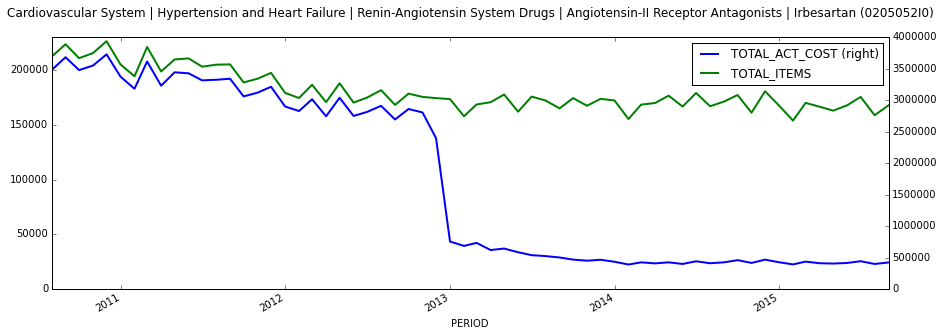

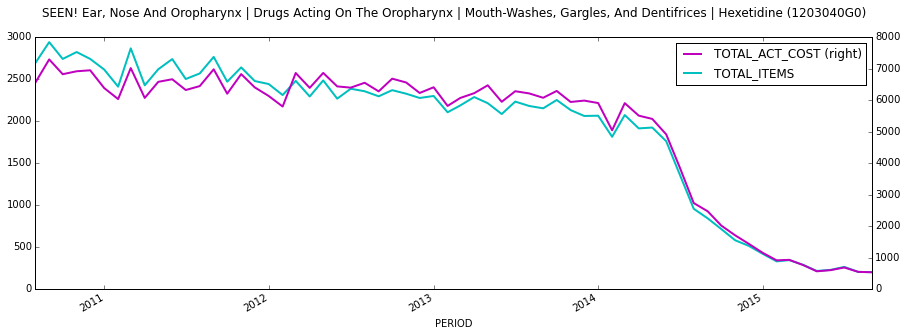

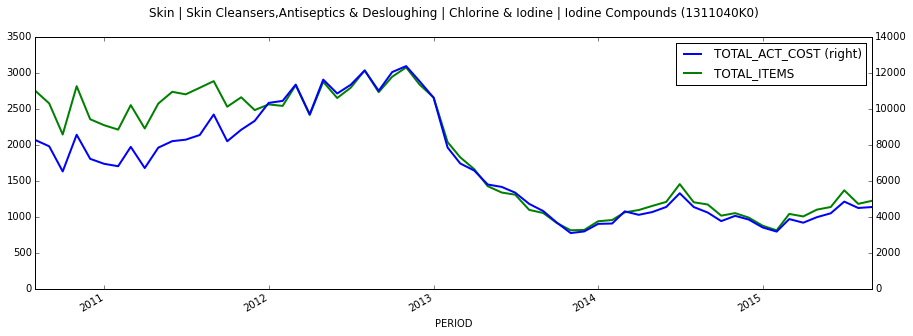

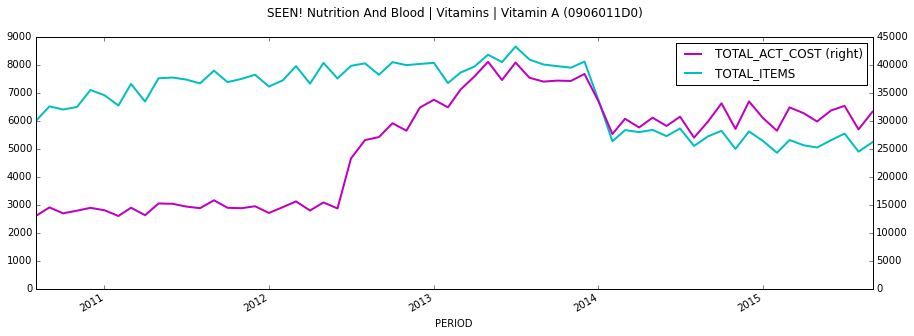

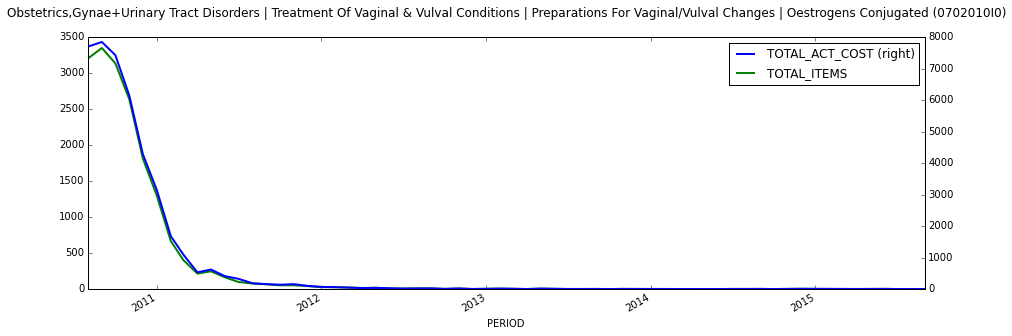

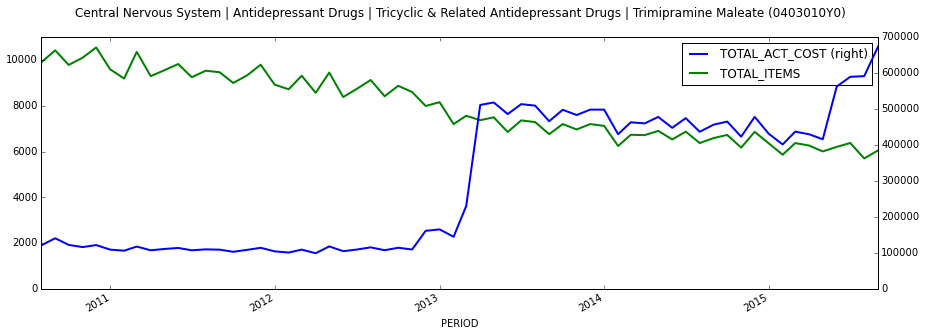

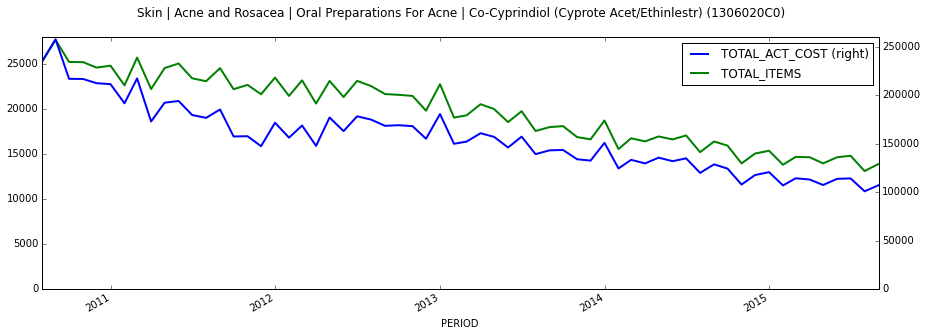

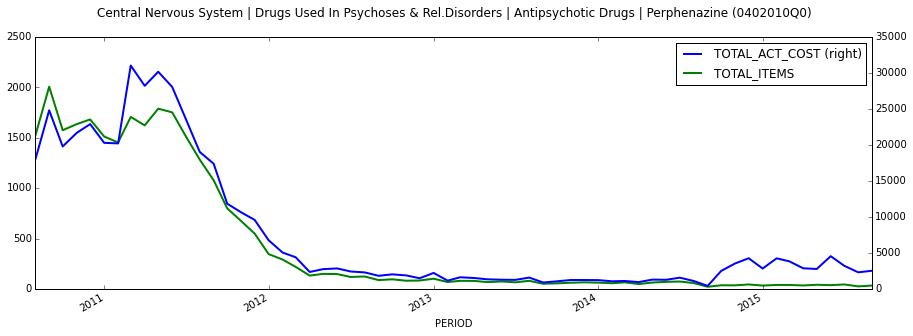

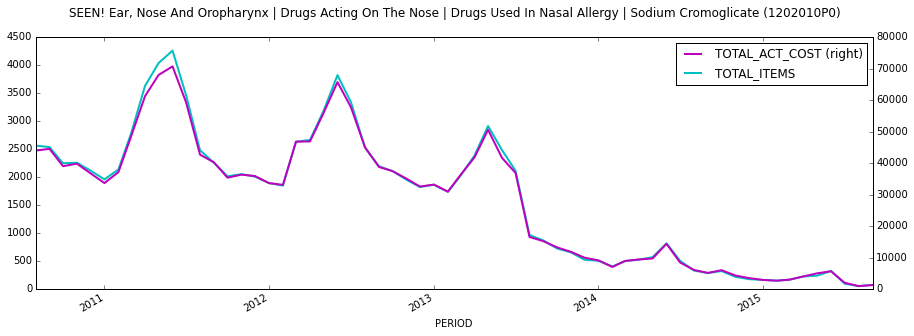

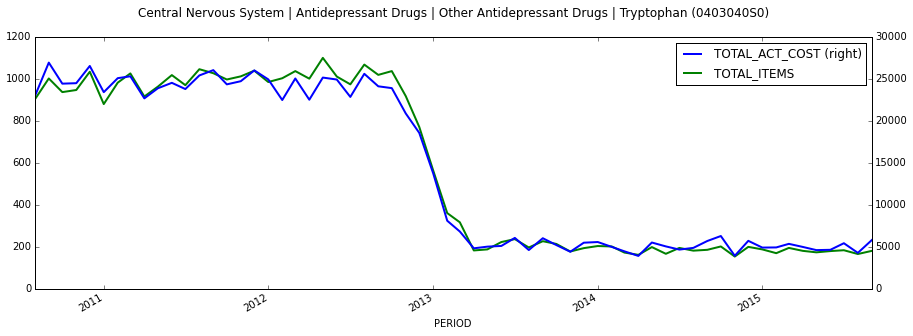

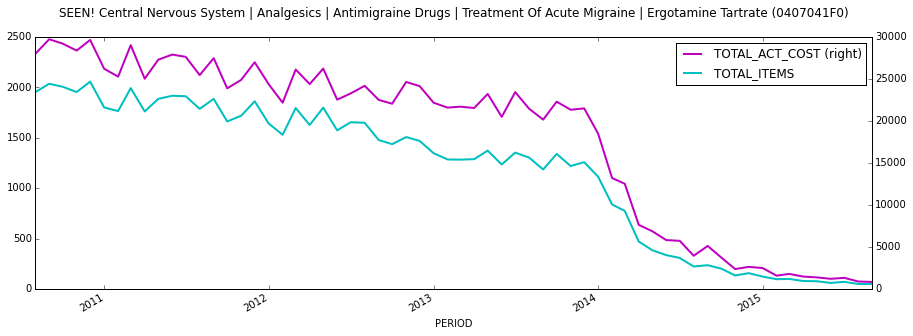

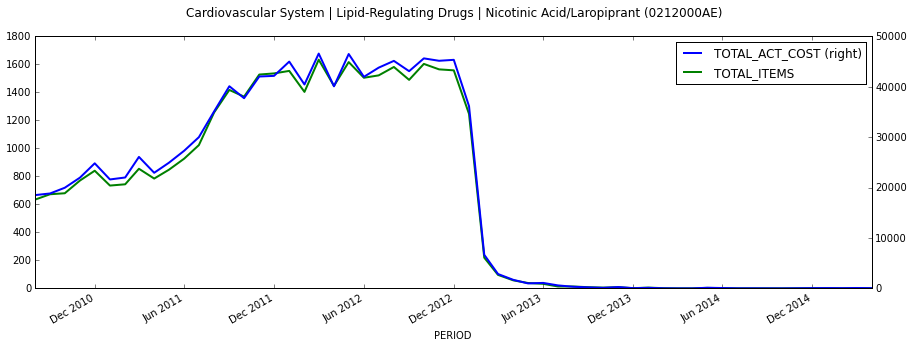

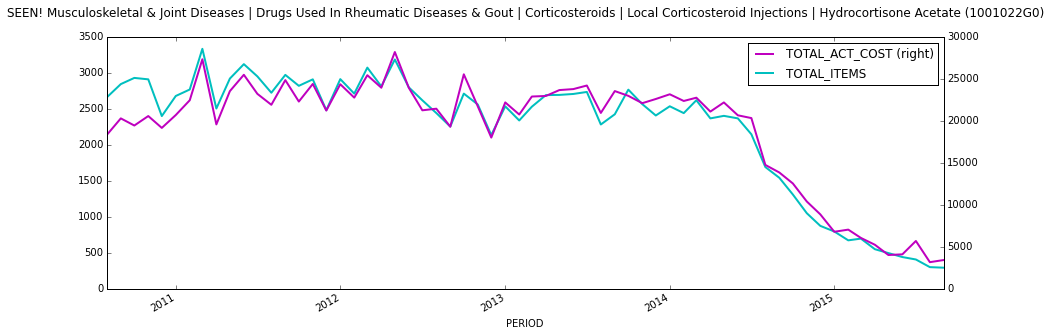

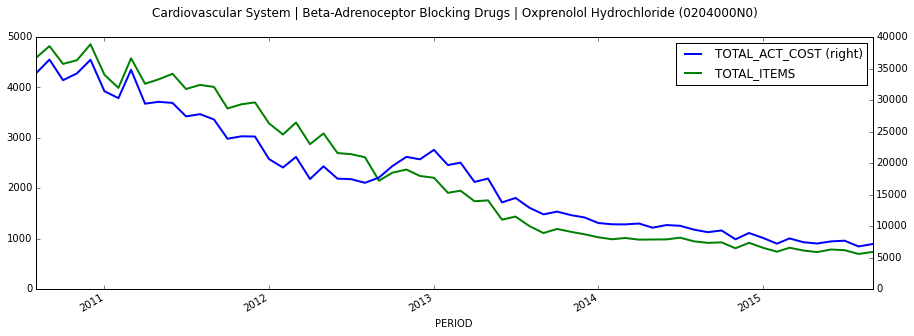

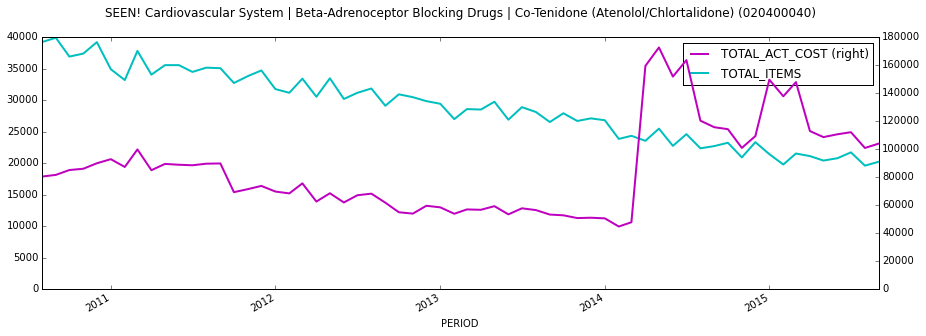

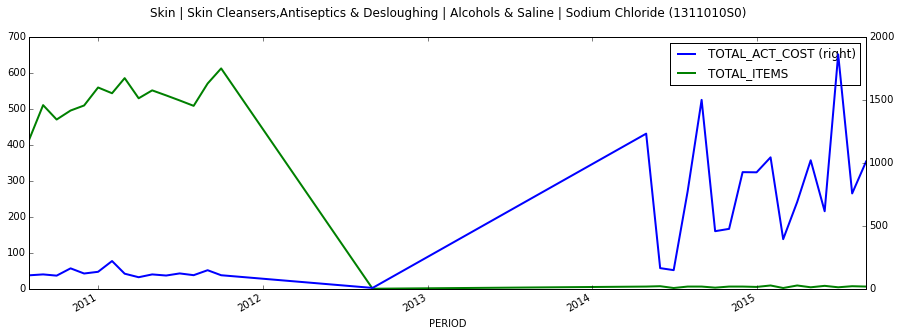

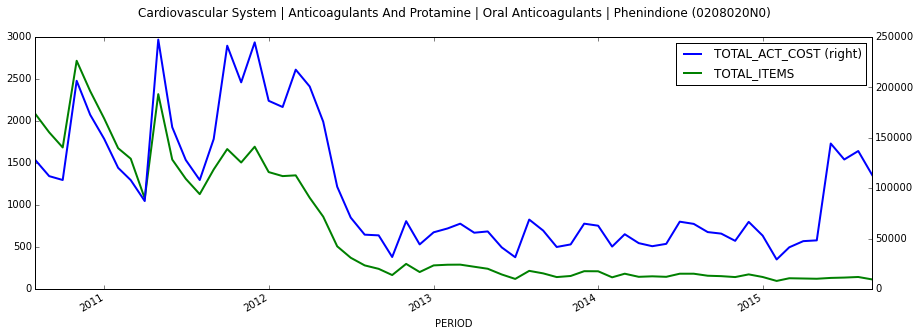

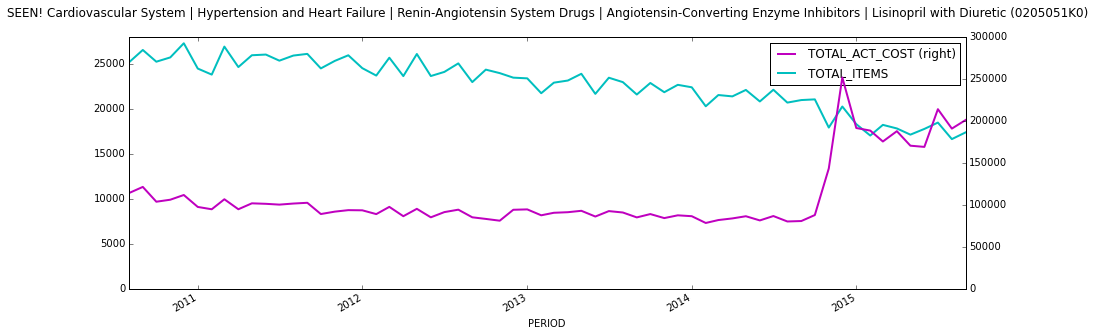

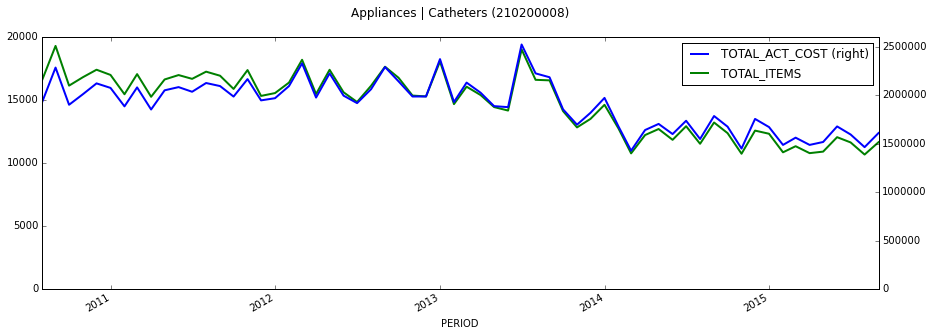

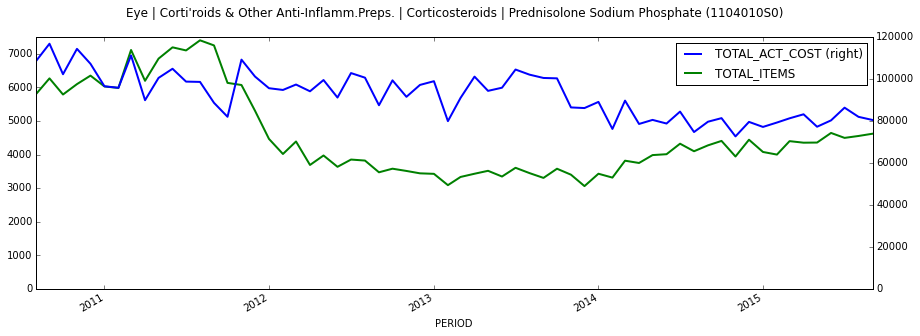

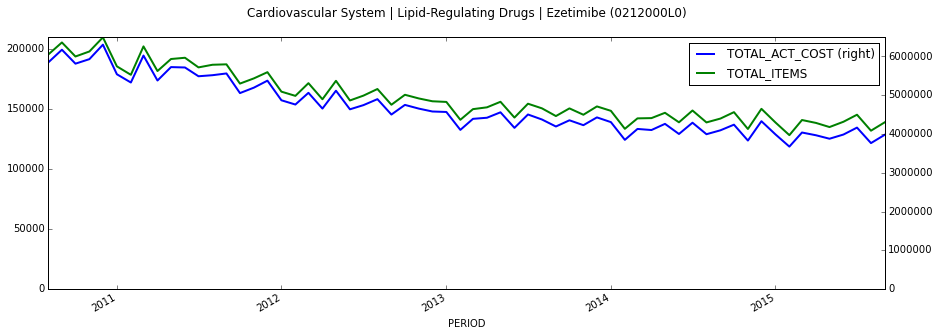

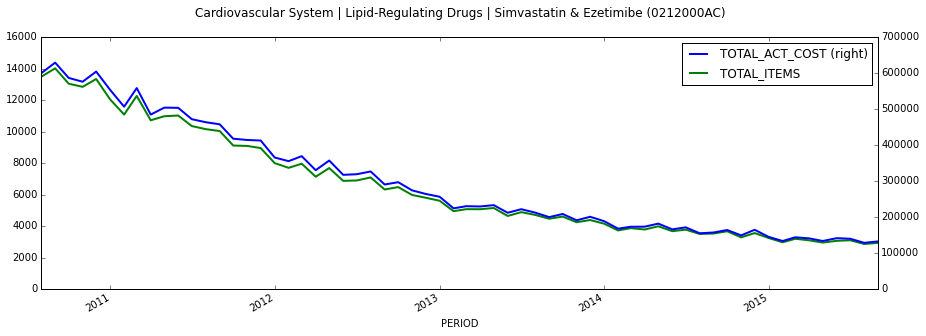

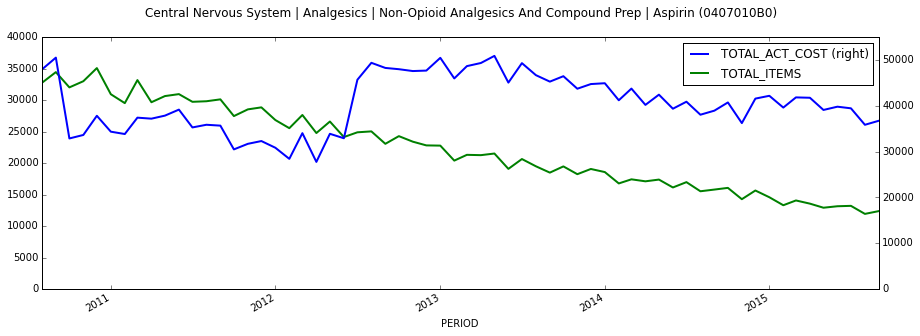

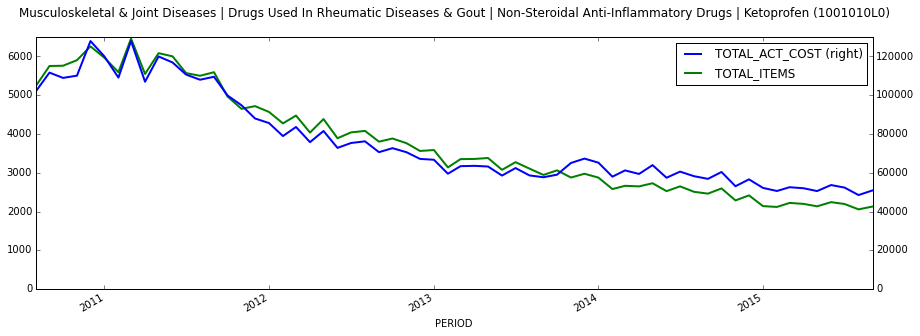

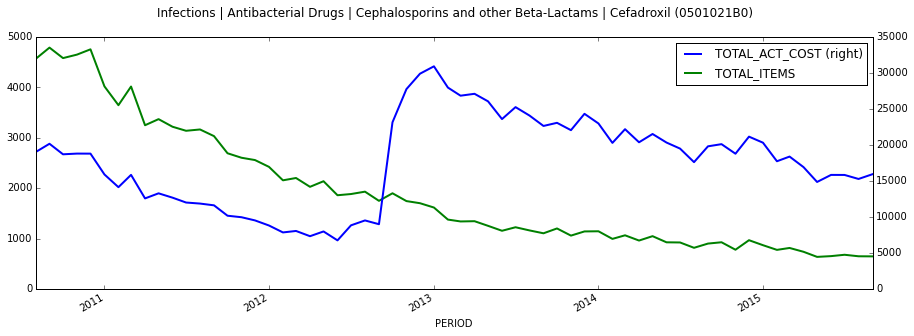

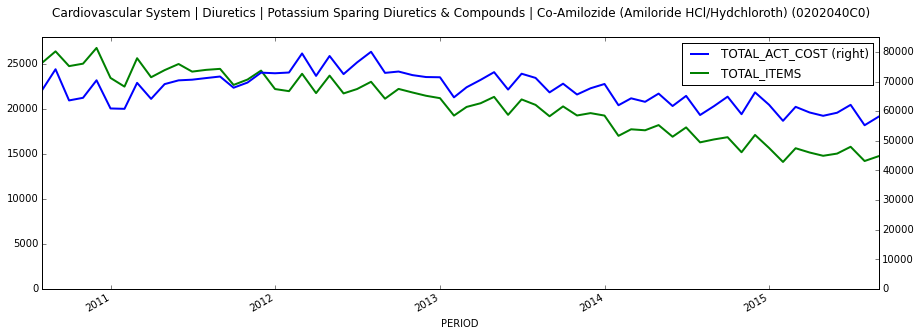

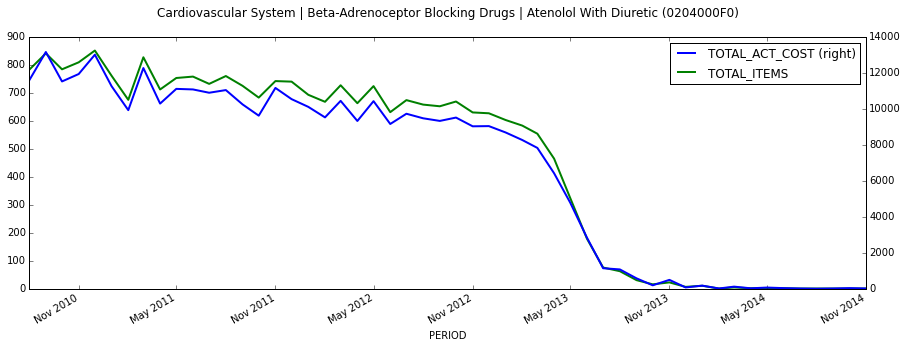

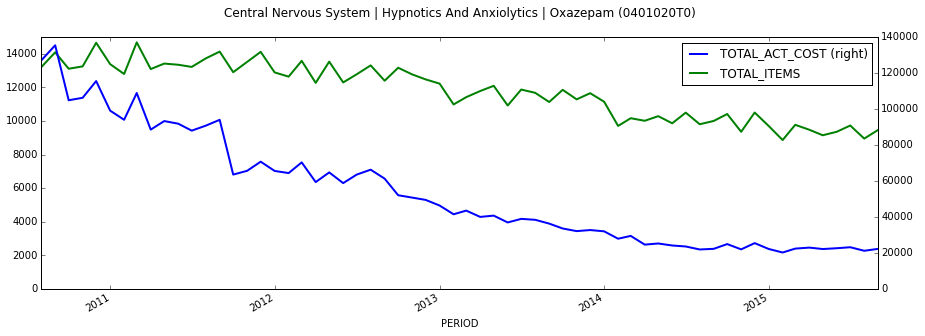

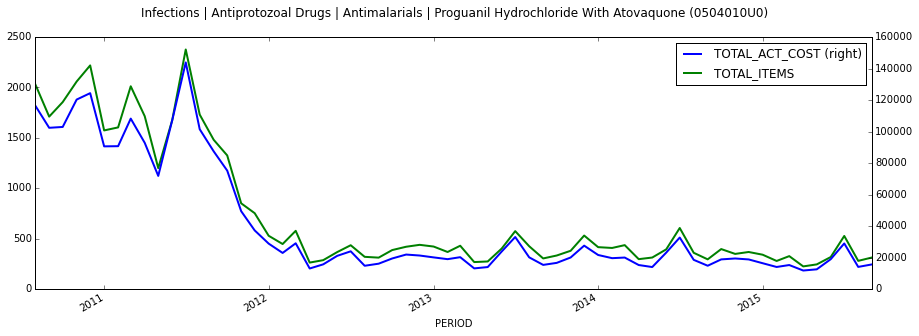

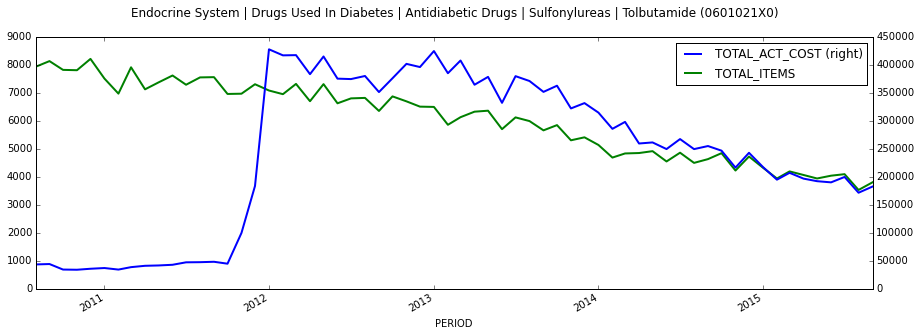

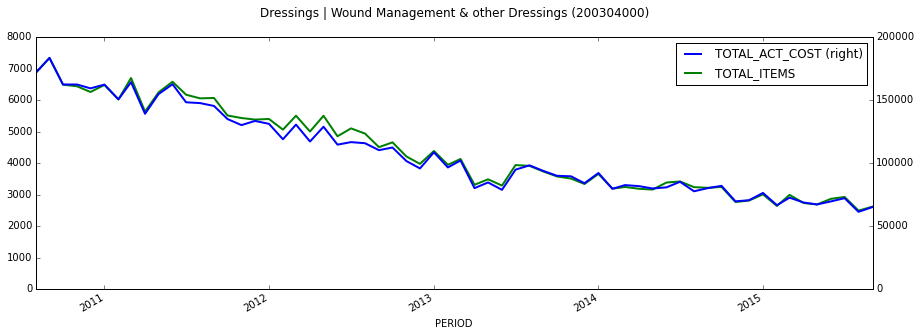

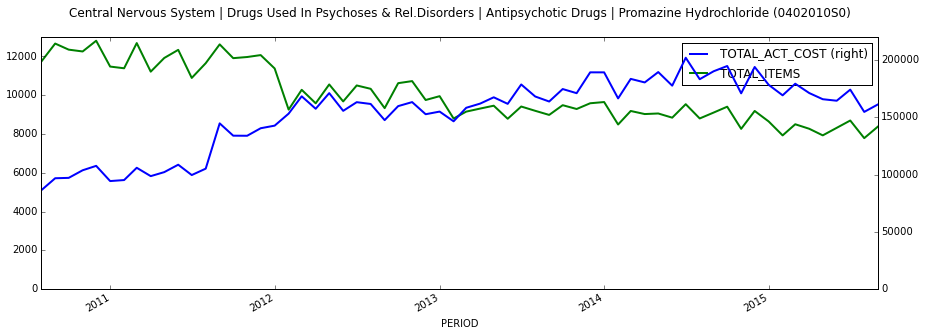

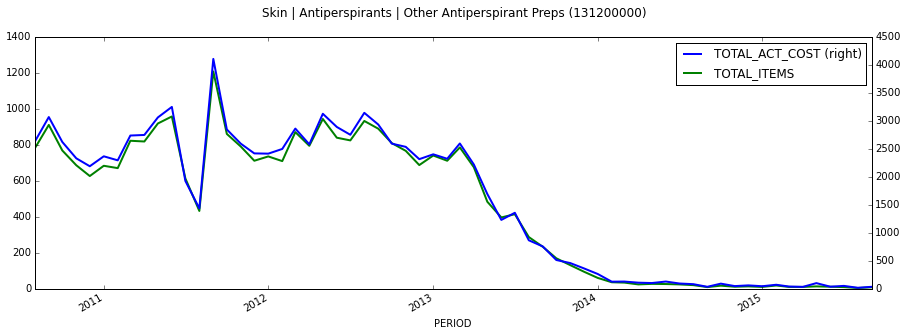

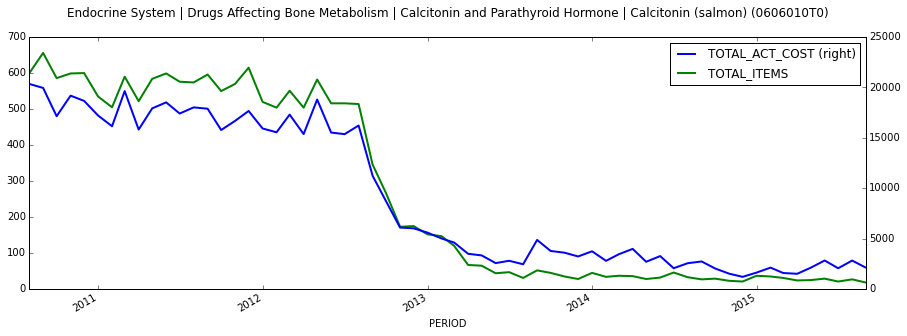

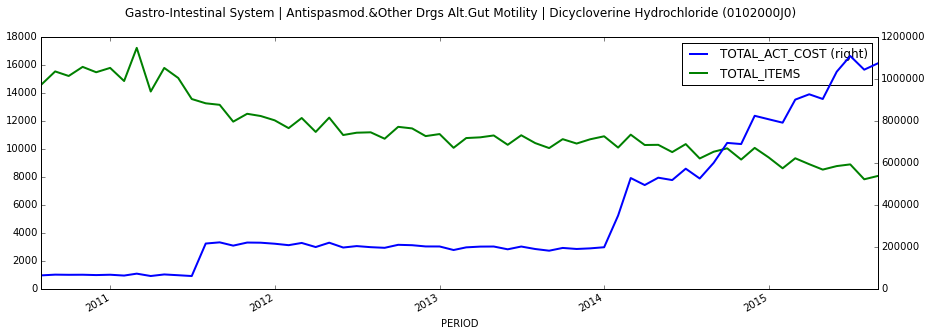

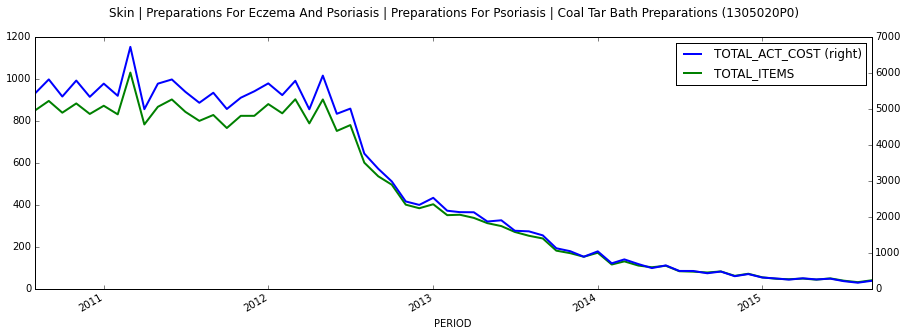

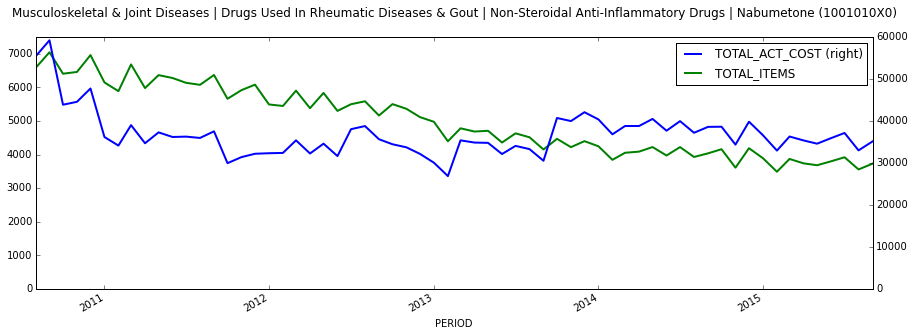

In [44]:
for highscorer in scores.sort(columns=['TOTAL_ITEMS'],ascending=False)[:100].index:
    title="%s (%s)\n" % (bnf.description(highscorer),highscorer)
    colours='bg'
    if highscorer in seen:
        title="SEEN! "+title
        colours='mc'
        
    ax=df.ix[highscorer].sort().plot(ylim=0,figsize=(15,5),linewidth=2,secondary_y=['TOTAL_ACT_COST'],
                                  title=title,colors=colours)
    ax.right_ax.set_ylim(0)

# Log of detected chemicals

In [43]:
for highscorer in scores.sort(columns=['TOTAL_ITEMS'],ascending=False)[:100].index:
    if highscorer in seen:
        print "SEEN!\t",
    else:
        print "\t",
    print highscorer,bnf.path(highscorer)[-1]


	0906040N0 Ergocalciferol
	1302010F0 Emulsifying Wax
SEEN!	0205052V0 Valsartan
SEEN!	1001010C0 Diclofenac Sodium
SEEN!	0406000J0 Domperidone
	0407010X0 Paracetamol Combined Preparations
SEEN!	1304000H0 Clobetasone Butyrate
	0703021C0 Etynodiol Diacetate
SEEN!	0904010U0 Gluten Free/Wheat Free Bread
SEEN!	0202040B0 Co-Amilofruse (Amiloride HCl/Frusemide)
SEEN!	1201010Q0 Hydrocortisone
SEEN!	0209000L0 Dipyridamole
SEEN!	0212000AB Omega-3-Acid Ethyl Esters
SEEN!	0401010T0 Temazepam
	0205051J0 Fosinopril Sodium
	0606020X0 Strontium Ranelate
	0104020H0 Co-Phenotrope (Diphenox HCl/Atrop Sulph)
	1203050M0 Malic Acid
	0402010X0 Trifluoperazine
	1306010C0 Benzoyl Peroxide
	091200000 Other Health Supplement Preps
	0205052Q0 Telmisartan
	100302010 Ketoprofen
	1306010V0 Tretinoin
SEEN!	1003020T0 Nicotinates
	0103050T0 Rabeprazole Sodium
	0405010P0 Orlistat
	1305020I0 Coal Tar & Corticosteroid Preparations
SEEN!	210200002 Catheters
	0205052B0 Olmesartan Medoxomil
SEEN!	0410020B0 Nicotine Dependence
